# Second home assignment Social Data Science

Team Members
1.Anna Wegmann - 330509
2.Ulfet Cetin- 391819
3.Shreya Kar- 392325

## Mahalanobis matching
Another popular alternative to propensity score matching is "Mahalanobis matching". This is a greedy matching method, where each point of one group is matched to its nearest neighbor according to the Mahalanobis distance, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.mahalanobis.html for a formal definition. 



### Data preparation:
We apply Mahalanobis matching to the quality of government (QoG) data from the last home assignment. For this task, first load the QoG data into a pandas dataframe and select the columns "cname","wdi_lifexp" (life expectancy),"wdi_popden"(population density),"gle_cgdpc" (GDP per capita), "bti_ds" (Democracy Status).

Remove all countries with missing values. Then put all remaining countries into two groups:
* Full democratic (bti_ds > 8.0)
* Not full democratic (else)

In [6]:
# import libraries
import pandas as pd
import scipy
import numpy as np
from scipy import spatial

In [7]:
dataSet = pd.read_csv('qog_bas_cs_jan18.csv')
columnNames = ["cname", "wdi_lifexp", "wdi_popden", "gle_cgdpc", "bti_ds"]

# remove missing values
filteredData = dataSet[columnNames].dropna()

In [8]:
democratic = filteredData[filteredData["bti_ds"]>8.0]
notDemocratic = filteredData[filteredData["bti_ds"]<=8.0]

# print(democratic["cname"])
# print()
# print(notDemocratic["cname"])
# print()
# print(filteredData)

### a) Compute the Mahalanobis distance matrix with respect to the attribute population density and gdp per capita.
You can use all functions from numpy/scipy/scikit-learn for this!

In [9]:
# choose the fields required
composition1 = filteredData["wdi_popden"]
composition2 = filteredData["gle_cgdpc"]

# calculated covariance and inverse matrix of covariance
covariance = np.cov(composition1, composition2)
inverseOfCovariance = np.linalg.inv(covariance)

In [10]:
# create an empty matrix to be populated later
numberOfCountries = len(filteredData["cname"])
result = np.zeros( (numberOfCountries, numberOfCountries) )

# iterate over to calculate mahalanobis distances
# populate the result matrix accordingly
for ind_1 in range(numberOfCountries):
    for ind_2 in range(numberOfCountries):
        x = filteredData[["wdi_popden", "gle_cgdpc"]].iloc[[ind_1]]
        y = filteredData[["wdi_popden", "gle_cgdpc"]].iloc[[ind_2]]
        result[ind_1,ind_2] = scipy.spatial.distance.mahalanobis(x, y, inverseOfCovariance)

In [11]:
result

array([[0.        , 0.57724045, 0.36103969, ..., 0.77255722, 0.0738152 ,
        0.07849645],
       [0.57724045, 0.        , 0.24802164, ..., 0.22355037, 0.50430004,
        0.51884035],
       [0.36103969, 0.24802164, 0.        , ..., 0.41516357, 0.28792537,
        0.29105487],
       ...,
       [0.77255722, 0.22355037, 0.41516357, ..., 0.        , 0.69875686,
        0.70560509],
       [0.0738152 , 0.50430004, 0.28792537, ..., 0.69875686, 0.        ,
        0.0409606 ],
       [0.07849645, 0.51884035, 0.29105487, ..., 0.70560509, 0.0409606 ,
        0.        ]])

### b) Matching:
Investigate if there is a statistical association between "Full Democratic" and "Not Full Democratic" on one hand and life expectancy on the other hand.
For that purpose, compute a full greedy matching according to the Mahalanobis distance w.r.t population density and gdp per capita. Determine for yourself a reasonable threshold when no a match should be discarded (i.e., there is no suitable match for a country in the other group). Compare the life expectancy in the two groups.

Interpret and critically discuss the trustworthiness of the results.

In [12]:
# the following commented out code is taken from the lecture notes:
# https://www3.elearning.rwth-aachen.de/ws18/18ws-191315/Lists/
# StructuredMaterials/exercises/05e_matching_solution.ipynb

# our solution will be based on it (as it is given as a lecture material)

# def greedy_matching (group_1,group_2):
#     group_1 = group_1.copy()
#     #for each element in the smaller group pick one greedily from the first group
#     matching = {}
#     for i,o2 in enumerate(group_2):
#         #compute distances:
#         distances = [euclidean_distance (o2, o1) for o1 in group_1]
#         #find the index of the best match for element o2
#         best_match = np.argmin(distances)
#         #store the matching
#         matching [best_match] = i
#         #prevent matching the same best_match again
#         group_1[best_match].fill (np.inf)     
#     return matching

countryIndexDict = {}
indexForDict = 0
for index, row in filteredData.iterrows():
    countryName = row["cname"]
    countryIndex = indexForDict
    countryIndexDict[countryName] = countryIndex
    indexForDict += 1


def greedyMatching(democraticVar, nonDemocraticVar, distanceMatrix):
    # dictionary of return ^^
    matchingDict = {}
    scoresDict = {}

    # both groups are of same length, so pick one (we pick group2)
    previouslySelectedList = []
    
    # iterate over countries
    # democraticVar is smaller group, so pick one it
    for i, row1 in democraticVar.iterrows():
        index1 = countryIndexDict[row1["cname"]]
        # find the best match
        bestScore = np.inf
        bestMatch = None
        for j, row2 in nonDemocraticVar.iterrows():
            index2 = countryIndexDict[row2["cname"]]
            # if for i value -> we selected a match,
            #    then, "continue" it as we are greedy
            if index2 in previouslySelectedList:
                continue
            
            # if we found a better score, update our current best variables
            # ANNA: should it be < or > for Mahalanobis distance ?? < since it is a distance
            if distanceMatrix[index1][index2] < bestScore:
                bestScore = distanceMatrix[index1][index2]
                bestMatch = index2
            
        # set the best match,
        # do not forget to add i to previouslySelectedList
        # so we do not overwrite it in next iterations
        previouslySelectedList.append(bestMatch)
        matchingDict[index1] = bestMatch
        scoresDict[index1] = bestScore
    
    # sorry, ad-hoc solution
    # hate to do ad-hoc :(
    # switch to filteredData index form (instead of the form above)
    newDict = {}
    newScoreDict = {}
    for key in matchingDict.keys():
        val = matchingDict[key]
        score_in_filtered = scoresDict[key]
        key_in_filtered = filteredData.iloc[key].name
        val_in_filtered = filteredData.iloc[val].name
        newDict[key_in_filtered] = val_in_filtered
        newScoreDict[key_in_filtered] = score_in_filtered
        
    # matchingDict uses relative indexing
    # use whatever return use want to use, i prefer the latter
    
    # note that newDict uses index given by Pandas 
    # (the one that appear on the mostleft field when printing Pandas dataframe)
    return newDict, newScoreDict

matchDict, scoresDict = greedyMatching(democratic, notDemocratic, result)

for key in matchDict.keys():
    val = matchDict[key]
    score = scoresDict[key]
    print(key, ":",  val)
    
    demCountry = filteredData.loc[key]["cname"]
    nonDemCountry = filteredData.loc[val]["cname"]
    print(demCountry, ":", nonDemCountry)
    
    print("Score:", score)
    
    print()

19 : 178
Botswana : Turkmenistan
Score: 0.0349204771205808

20 : 135
Brazil : Peru
Score: 0.04860075395292411

24 : 110
Bulgaria : Mexico
Score: 0.028597279721248446

35 : 7
Chile : Argentina
Score: 0.03255889832254219

42 : 182
Costa Rica : Macedonia
Score: 0.021831798694790707

43 : 27
Croatia : Belarus
Score: 0.04123842086779771

46 : 150
Czech Republic : Saudi Arabia
Score: 0.2532411997239862

56 : 143
Estonia : Russia
Score: 0.05676984216433448

84 : 157
Jamaica : Vietnam
Score: 0.06968269472677867

90 : 117
Korea, South : Oman
Score: 0.7874692128834171

96 : 161
Latvia : Zimbabwe
Score: 0.05350793121349837

100 : 74
Lithuania : Hungary
Score: 0.09299289792788276

109 : 94
Mauritius : Lebanon
Score: 0.36330059449138247

137 : 175
Poland : United Arab Emirates
Score: 0.04063116754601177

142 : 114
Romania : Montenegro
Score: 0.05943947644791214

156 : 177
Slovakia : Turkey
Score: 0.39806074631676136

158 : 132
Slovenia : Panama
Score: 0.7506821306959449

188 : 78
Uruguay : Iran
Sco

In [13]:
# threshold (maybe 0.1)
def filter_threshold(matchDict, scoresDict, threshold):
    filteredMatchDict = {}
    filteredScoreDict = {}
    for key in matchDict.keys():
        val = matchDict[key]
        score = scoresDict[key]
        if score < threshold:
            filteredMatchDict[key] = val
            filteredScoreDict[key] = score
            print(key, ":",  val)

            demCountry = filteredData.loc[key]["cname"]
            nonDemCountry = filteredData.loc[val]["cname"]
            print(demCountry, ":", nonDemCountry)

            print("Score:", score)

            print()
    return filteredMatchDict, filteredScoreDict
filteredMatchDict, filteredScoreDict = filter_threshold(matchDict, scoresDict, 0.1)

19 : 178
Botswana : Turkmenistan
Score: 0.0349204771205808

20 : 135
Brazil : Peru
Score: 0.04860075395292411

24 : 110
Bulgaria : Mexico
Score: 0.028597279721248446

35 : 7
Chile : Argentina
Score: 0.03255889832254219

42 : 182
Costa Rica : Macedonia
Score: 0.021831798694790707

43 : 27
Croatia : Belarus
Score: 0.04123842086779771

56 : 143
Estonia : Russia
Score: 0.05676984216433448

84 : 157
Jamaica : Vietnam
Score: 0.06968269472677867

96 : 161
Latvia : Zimbabwe
Score: 0.05350793121349837

100 : 74
Lithuania : Hungary
Score: 0.09299289792788276

137 : 175
Poland : United Arab Emirates
Score: 0.04063116754601177

142 : 114
Romania : Montenegro
Score: 0.05943947644791214

188 : 78
Uruguay : Iran
Score: 0.04086739937450757



In [14]:
# we chose a threshold of 0.1 because:
# it only filters out 5 matchings and the remaining matchings have comparable scores [low range of values]
# > the remaining matchings have a score between 0 and 0.1 (13 matchings)
# > the filtered matchings have a score between 0.25 and 0.8 (5 matchings)

In [15]:
n_unfiltered = len(matchDict.keys())
n_filtered = len(filteredMatchDict.keys())
print(n_unfiltered)
print(n_filtered)

18
13


In [16]:
avg_dem = 0
avg_non_dem = 0
for key in filteredMatchDict.keys():
    val = filteredMatchDict[key]
    avg_dem += filteredData.loc[key]["wdi_lifexp"]
    avg_non_dem += filteredData.loc[val]["wdi_lifexp"]
avg_dem = avg_dem/len(filteredMatchDict.keys())
avg_non_dem = avg_non_dem/len(filteredMatchDict.keys())
avg_dem - avg_non_dem

2.063575157752396

In [17]:
# Interpretation (life expectancy to Democratic/Non-Democratic)
# it seems like life expectancy in democratic countries is on average 2 years higher than in non-democratic countries

In [18]:
# Discussion of trustworthiness of results:
# - greedy is not optimal matching
# - maybe not enough data points?
# - the threshold may be too high/low
# - we only controlled for  population density and gdp per capita, there could be more confounders

# Schelling‘s Model of Segregation

### a) Create grid
Wbrite a function create_grid (shape, share_red, share_blue) that returns a numpy array of the given shape (rows, columns). Cells with a red agent should be marked with the value 1, cells with a blue agent with value 2, empty cells with a 0.

Naturally, share_red + share_blue < 1

In [19]:
#Source:
#https://www.binpress.com/simulating-segregation-with-python/

In [20]:
import numpy as np
import random as rand
def create_grid(shape,share_red,share_blue):
    # create grid of dim of shape(rows,columns)
    rows=shape[0]
    columns=shape[1]
    grid=np.zeros(shape)
    #converting proportion to integer value
    share_red=int(share_red*rows*columns)
    share_blue=int(share_blue*rows*columns)
    #initializing empty locations to red agents i.e. value 1
    while(share_red!=0):
        i=rand.randint(0,rows-1)
        j=rand.randint(0,columns-1)
        if(grid[i][j]==0):
            share_red=share_red-1
            grid[i][j]=1
    #initializing empty locations to blue agents i.e. value 2
    while(share_blue!=0):
        i=rand.randint(0,rows-1)
        j=rand.randint(0,columns-1)
        if(grid[i][j]==0):
            share_blue=share_blue-1
            grid[i][j]=2
            
    return grid
            
grid=create_grid((4,4),0.50,0.30)
grid

array([[1., 2., 1., 0.],
       [0., 2., 0., 1.],
       [0., 1., 1., 1.],
       [2., 2., 1., 1.]])

### b) Visualization

Write a function visualize(grid) that take a numpy array with these properties and plots it. We recommend to use matplotlib for this

In [21]:
#Sources:
#https://matplotlib.org/tutorials/colors/colormap-manipulation.html
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.matshow.html

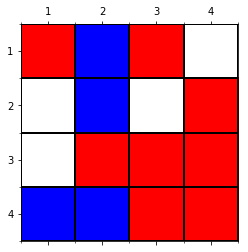

In [23]:
import matplotlib.pyplot as plt
from matplotlib import colors
def visualize(grid):
    fig, ax = plt.subplots()
    rows=grid.shape[0]
    columns=grid.shape[1]
    #initialising an array with rgb values of colors to map value to its respective color in the grid
    agent_colors = ['r','b']
    cm=[(1,1,1),(1,0,0),(0,0,1)]
    ax.matshow(grid,cmap=colors.ListedColormap(cm))
    # Major ticks
    ax.set_xticks(np.arange(0, rows, 1));
    ax.set_yticks(np.arange(0, columns, 1));

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, rows+1, 1));
    ax.set_yticklabels(np.arange(1, columns+1, 1));

    # Minor ticks
    ax.set_xticks(np.arange(-.5, rows, 1), minor=True);
    ax.set_yticks(np.arange(-.5, columns, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='#000000',linestyle='-', linewidth=2)
visualize(grid)    

### c) Simulation Step

Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportion)

In [25]:
#function to check if the agent is satisfied or satisfied
def satisfied(i,j,grid,preferred_proportion):
    rows=grid.shape[0]-1
    columns=grid.shape[1]-1
    agent_race=grid[i][j]
    count_same_neighbour_agent=0
    count_neighbour_agent=0
    #neighbours to the left
    x=i-1
    y=j-1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #right neighbours
    x=i+1
    y=j+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #neighbours of same row
    x=i-1
    y=j
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #check if current grid has dissatisfied member
    proportion_same_neighbours=count_same_neighbour_agent/count_neighbour_agent
    if(proportion_same_neighbours<preferred_proportion):
        return False
    return True
#function to move dissatisfied member to empty space in the grid
def move_agent(x,y,grid):
    flag=0
    while(flag==0):
        i=rand.randint(0,grid.shape[0]-1)
        j=rand.randint(0,grid.shape[1]-1)  
        if(grid[i][j]==0):
            t=grid[x][y]
            grid[x][y]=0
            grid[i][j]=t
            flag=1
    return grid
#simulate potential movement of a single randomly picked agent
def simulate(grid,preferred_proportion):
        rows=grid.shape[0]
        columns=grid.shape[1]
        i=rand.randint(0,grid.shape[0]-1)
        j=rand.randint(0,grid.shape[1]-1)
        while(grid[i][j]==0):
            i=rand.randint(0,grid.shape[0]-1)
            j=rand.randint(0,grid.shape[1]-1)
            
        if not satisfied(i,j,grid,preferred_proportion):
            new_grid=move_agent(i,j,grid)
            #print(new_grid)
            return True
        #no change
        return False
        
print('Grid before single step simulation:',grid)
print('Grid after single step simulation:')
simulate(grid,1.0)
print(grid)

Grid before single step simulation: [[1. 2. 1. 0.]
 [0. 2. 1. 1.]
 [0. 0. 1. 1.]
 [2. 2. 1. 1.]]
Grid after single step simulation:
[[1. 2. 1. 0.]
 [2. 2. 1. 1.]
 [0. 0. 1. 1.]
 [0. 2. 1. 1.]]


In [26]:
simulate(grid,0.70)
print(grid)

[[1. 2. 1. 0.]
 [0. 2. 1. 1.]
 [0. 2. 1. 1.]
 [0. 2. 1. 1.]]


### d) Full Simulation

Write a function simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization) that performs a full simulation of Schelling's model given a specific start state by performing steps until the maximum number of steps is reached or the was no change for the given amount of steps. Every iterations_to_next_vizualization steps, a visualization of the model should be plotted.


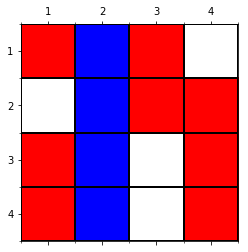

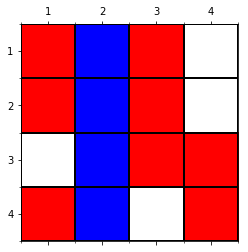

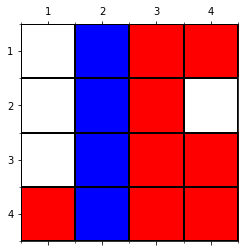

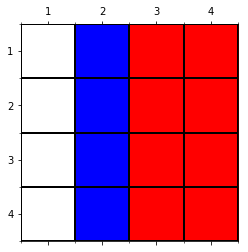

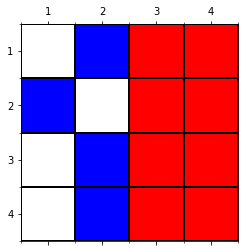

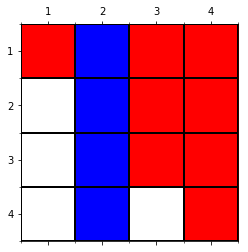

In [27]:
#function to simulate grid till max number of steps are reached or no change steps are reached
def simulate_full(grid,preferred_proportion,max_steps,no_changes_steps,iterations_to_next_vizualization):
    #variable to keep track of max number of steps
    steps=0
    #variable to keep track of no change steps
    track_change=0
    # boolean variable to track if grid has changed
    changed=False
    while(steps<max_steps and track_change<no_changes_steps):
        changed=simulate(grid,preferred_proportion)
        if(changed):
            track_change=0
        else:
            track_change+=1
        steps=steps+1
        if(steps%iterations_to_next_vizualization==0):
            #iterations_to_next_visualization reached
            visualize(grid)
simulate_full(grid,1,20,5,3)        
        
        

### e) Model Extension

Edit your functions such that they support multiple groups (instead of just red and blue), and each group can have a separate preferred proportion. Use for this the following signatures

create_grid (shape, shares): percentages should be a list of shares for each color
visualize(grid) => choose appropriate colors
Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportions) => Gives a list of preferred proportions for each color.


[90, 22, 45, 22]
Result of create grid: [[3. 2. 1. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1.]
 [1. 0. 1. 3. 1. 1. 3. 1. 1. 3. 3. 1. 0. 1. 3.]
 [1. 4. 1. 3. 2. 4. 3. 2. 1. 0. 3. 1. 3. 0. 1.]
 [1. 3. 0. 1. 0. 0. 0. 4. 0. 1. 3. 1. 1. 4. 1.]
 [3. 0. 0. 1. 3. 2. 0. 4. 3. 0. 0. 3. 0. 1. 1.]
 [3. 1. 0. 4. 2. 3. 4. 0. 2. 1. 4. 1. 2. 1. 3.]
 [3. 3. 3. 2. 4. 4. 0. 1. 2. 3. 1. 0. 1. 1. 0.]
 [4. 1. 1. 0. 2. 0. 1. 3. 4. 0. 1. 1. 0. 1. 1.]
 [2. 0. 1. 2. 3. 3. 1. 0. 3. 1. 1. 1. 0. 0. 4.]
 [3. 1. 3. 1. 0. 0. 2. 1. 1. 0. 4. 1. 1. 1. 4.]
 [1. 2. 4. 4. 1. 1. 2. 1. 3. 3. 1. 1. 3. 1. 0.]
 [1. 0. 3. 0. 0. 0. 2. 1. 1. 1. 1. 2. 2. 0. 0.]
 [4. 1. 1. 1. 1. 3. 2. 3. 3. 4. 3. 1. 1. 0. 1.]
 [2. 1. 4. 4. 3. 3. 0. 3. 3. 0. 4. 0. 1. 3. 1.]
 [2. 1. 1. 1. 1. 3. 0. 2. 1. 1. 0. 0. 3. 1. 1.]]
[(1, 1, 1), (0.28627450980392155, 0.4823529411764706, 0.9333333333333333), (0.7098039215686275, 0.6039215686274509, 0.17647058823529413), (0.3215686274509804, 0.27058823529411763, 0.45098039215686275), (0.7333333333333333, 0.02352941176470

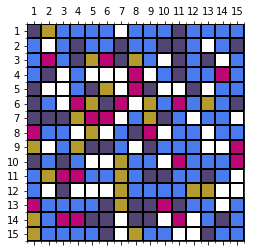

In [30]:
#list of preferred_proportion for each agent
shares=[0.40,0.10,0.20,0.10]
#initialize grid with diefferent agents
def create_grid(shape,shares):
    # create grid of dim of shape(rows,columns)
    rows=shape[0]
    columns=shape[1]
    grid=np.zeros(shape)
    #a list to store integer value of proportions of each agent i.e. if agent x has proportion 0.50
    #then 8 positions in a grid of 4x4 must be filled with agent x
    agent_race_share=[]
    #N is number of agents
    N=len(shares)
    for i in range(N):
        agent_race_share.append(int(shares[i]*rows*columns))
    print(agent_race_share)
    #initialize grid with agents
    for agent in range(len(agent_race_share)):
        n=agent_race_share[agent]
        while(n!=0):
            i=rand.randint(0,rows-1)
            j=rand.randint(0,columns-1)
            if(grid[i][j]==0):
                n-=1
                #adding plus 1 because agent is an index
                grid[i][j]=agent+1
            
    return grid
            
grid=create_grid((15,15),shares)
print('Result of create grid:',grid)

#function to visualise grid with n agents
def visualize(grid):
    fig, ax = plt.subplots()
    rows=grid.shape[0]
    columns=grid.shape[1]
    #find number of distinct agents
    number_of_distinct_agents=len(np.unique(grid))-1
    #use a color map with (r,g,b) values for each agent,initialise it with (r,g,b) value of white
    cmap=[(1,1,1)]
    #to run the simulation with n distinct agents, we need n distinct agent_colors
    agent_colors = ["#"+''.join([rand.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_distinct_agents)]
    #convert randomly genererated hex values of agent colors to rgb and append to cmap
    for c in agent_colors:
        rgb_val=colors.to_rgb(c)
        cmap.append(rgb_val)
    print(cmap)
    #plot matrix values with help of colormap
    ax.matshow(grid,cmap=colors.ListedColormap(cmap))
    # Major ticks
    ax.set_xticks(np.arange(0, rows, 1));
    ax.set_yticks(np.arange(0, columns, 1));

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, rows+1, 1));
    ax.set_yticklabels(np.arange(1, columns+1, 1));

    # Minor ticks
    ax.set_xticks(np.arange(-.5, rows, 1), minor=True);
    ax.set_yticks(np.arange(-.5, columns, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='#000000',linestyle='-', linewidth=2)
visualize(grid)

In [31]:
#function to check if agent is satistied or dissatisfied
def satisfied(i,j,grid,preferred_proportion):
    rows=grid.shape[0]-1
    columns=grid.shape[1]-1
    agent_race=grid[i][j]
    #variable that stores  count of neighbours of the same race
    count_same_neighbour_agent=0
    #variable that stores  count of neighbours
    count_neighbour_agent=0
    #neighbours to the left
    x=i-1
    y=j-1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #right neighbours
    x=i+1
    y=j+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #neighbours of same row
    x=i-1
    y=j
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    x=i+1
    if((x>=0 and x<=rows) and (y>=0 and y<=columns)):
        if (grid[x][y]==agent_race):
            count_same_neighbour_agent=count_same_neighbour_agent+1
        count_neighbour_agent=count_neighbour_agent+1
    #check if current grid has dissatisfied member
    proportion_same_neighbours=count_same_neighbour_agent/count_neighbour_agent
    if(proportion_same_neighbours<preferred_proportion):
        return False
    return True
#function to move disastified member to an empty place in the grid
def move_agent(x,y,grid):
    flag=0
    while(flag==0):
        i=rand.randint(0,grid.shape[0]-1)
        j=rand.randint(0,grid.shape[1]-1)  
        if(grid[i][j]==0):
            t=grid[x][y]
            grid[x][y]=0
            grid[i][j]=t
            flag=1
    return grid
#simulate potential movement of a single randomly picked agent
def simulate(grid,preferred_proportion):
        rows=grid.shape[0]
        columns=grid.shape[1]
        i=rand.randint(0,grid.shape[0]-1)
        j=rand.randint(0,grid.shape[1]-1)
        while(grid[i][j]==0):
            i=rand.randint(0,grid.shape[0]-1)
            j=rand.randint(0,grid.shape[1]-1)
        #pick agent
        agent_race=int(grid[i][j])   
        if not satisfied(i,j,grid,preferred_proportion[agent_race-1]):
            grid=move_agent(i,j,grid)
            #print(grid)
            return True
        #no change
        return False
        
#list with preferred proportion for each agent
preferred_proportion=[0.30,0.50,0.30,0.20]

print('Grid before single step simulation:',grid)
print('Grid after single step simulation:')
simulate(grid,preferred_proportion)
print(grid)

Grid before single step simulation: [[3. 2. 1. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1.]
 [1. 0. 1. 3. 1. 1. 3. 1. 1. 3. 3. 1. 0. 1. 3.]
 [1. 4. 1. 3. 2. 4. 3. 2. 1. 0. 3. 1. 3. 0. 1.]
 [1. 3. 0. 1. 0. 0. 0. 4. 0. 1. 3. 1. 1. 4. 1.]
 [3. 0. 0. 1. 3. 2. 0. 4. 3. 0. 0. 3. 0. 1. 1.]
 [3. 1. 0. 4. 2. 3. 4. 0. 2. 1. 4. 1. 2. 1. 3.]
 [3. 3. 3. 2. 4. 4. 0. 1. 2. 3. 1. 0. 1. 1. 0.]
 [4. 1. 1. 0. 2. 0. 1. 3. 4. 0. 1. 1. 0. 1. 1.]
 [2. 0. 1. 2. 3. 3. 1. 0. 3. 1. 1. 1. 0. 0. 4.]
 [3. 1. 3. 1. 0. 0. 2. 1. 1. 0. 4. 1. 1. 1. 4.]
 [1. 2. 4. 4. 1. 1. 2. 1. 3. 3. 1. 1. 3. 1. 0.]
 [1. 0. 3. 0. 0. 0. 2. 1. 1. 1. 1. 2. 2. 0. 0.]
 [4. 1. 1. 1. 1. 3. 2. 3. 3. 4. 3. 1. 1. 0. 1.]
 [2. 1. 4. 4. 3. 3. 0. 3. 3. 0. 4. 0. 1. 3. 1.]
 [2. 1. 1. 1. 1. 3. 0. 2. 1. 1. 0. 0. 3. 1. 1.]]
Grid after single step simulation:
[[3. 2. 1. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1.]
 [1. 0. 1. 3. 1. 1. 3. 1. 1. 3. 3. 1. 0. 1. 3.]
 [1. 4. 1. 3. 2. 4. 3. 2. 1. 0. 3. 1. 3. 0. 1.]
 [1. 3. 0. 1. 0. 0. 0. 4. 0. 1. 3. 1. 1. 4. 1.]
 [3. 0. 0. 1. 3.